

# Ephaptic Coupling #

### Import stuff

In [1]:
%pylab inline

import numpy as np
import sys
if sys.version < '3':
    from urllib2 import urlopen
else:    
    from urllib.request import urlopen
import ssl
from warnings import warn
import zipfile
import os
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import LFPy
import neuron
from custom_plots import plot_cell

Populating the interactive namespace from numpy and matplotlib


### Define morphology and cell parameters

https://senselab.med.yale.edu/ModelDB/ShowModel?model=243446&file=/purkinje_pub/purkinje_demo.hoc#tabs-1Ra 
https://www.jneurosci.org/content/jneuro/25/2/464.full.pdf
https://neuroelectro.org/neuron/18/

In [2]:
cellParameters = {
    'morphology' : 'morphology/purkinje.hoc',
    'cm' : 0.65,                # membrane conductance       
    'Ra' : 120,                 # axial resistance
    'v_init' : -62,             # initial membrane potential
    'passive' : True,           # turn on NEURONs passive mechanism for all sections
    'nsegs_method' : None,      # spatial discretization method
    'dt' : 2**-6,               # simulation time step size
    'tstart' : 0,               # start time of simulation
    'tstop' : 400,              # stop simulation
    'celsius': 34,              
    'pt3d' : True,
    'extracellular': True,      # extracellular electric field
    'passive_parameters' : {'g_pas' : 1/120236, 'e_pas' : -62},   # passive conductance and passive current
}

## Create generator_cell

	1 
	30 
	0 
	0 
	0 
	0 
Purkinje cell morphology defined

	1 
Overwriting custom temperature of 34.00. New temperature is 34.00
Synapse target index is: 4
Synapse target position is: [ 0.33033896 -1.38916722]
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma s

Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-

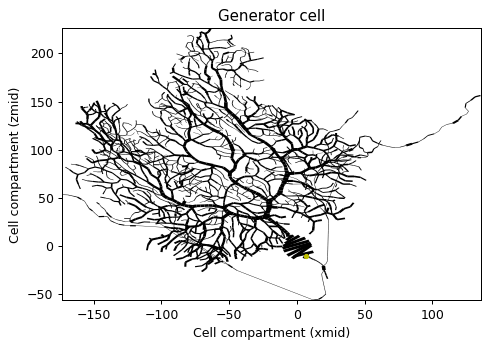

In [22]:
# delete old sections from NEURON namespace
LFPy.cell.neuron.h("forall delete_section()")

# initialize cell instance, using the LFPy.Cell class
generator_cell = LFPy.Cell(**cellParameters)
generator_cell.set_rotation(x=4.729, y=-3.166)

# create synapse
synapse_parameters = {
    'idx' : generator_cell.get_closest_idx(x=0, y=0, z=0),  # place sinapse at soma coordinates
    'e' : 0,                     # reversal potential
    'syntype' : 'ExpSyn',        # synapse type
    'tau' : 7.6,                 # purkinje synaptic time constant
    'weight' : 0.003,            # synaptic weight
    'record_current' : True,     # record synapse current
}

synapse = LFPy.Synapse(generator_cell, **synapse_parameters)
synapse.set_spike_times(np.array([95, 195]))      # spike times

# check synapse location 
positions = np.array(list(zip(generator_cell.xmid, generator_cell.zmid)))  # array all cell positions
synapse_index = generator_cell.get_closest_idx(x=0, y=0, z=0)              # find closest electrode to target position
synapse_pos = positions[synapse_index] 

print('Synapse target index is:', synapse_index)
print('Synapse target position is:', synapse_pos)

# plot generator cell morphology with synapse location
plt.figure(figsize=(6,4), dpi=90)
plot_cell(generator_cell, color='k')
plt.scatter(generator_cell.xmid[0],generator_cell.zmid[0], s=30, color='c', marker='D')
plt.title('Generator cell')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')
plt.savefig('purkinje_gen_synapse.png', dpi=300)

# define parameters for extracellular recording electrodes
electrodeParameters = {
    'sigma' : 0.6,                  # extracellular conductivity 0.6 to 0.24
    'x' : generator_cell.xmid+100,      
    'y' : generator_cell.ymid,
    'z' : generator_cell.zmid,
    'method' : 'soma_as_point',     #sphere source soma segment
    'N' : np.array([[0, 1, 0]]*generator_cell.xmid.size), #surface normals
    'r' : 2.5,                      # contact site radius
    'n' : 20,                       # datapoints for averaging
}

# create extracellular electrode object for LFPs on grid in xz-plane
electrode = LFPy.RecExtElectrode(**electrodeParameters)

# simulate generator cell
generator_cell.simulate(electrode = electrode,rec_vmem=True)

### Plot Vmem in generator cell over time

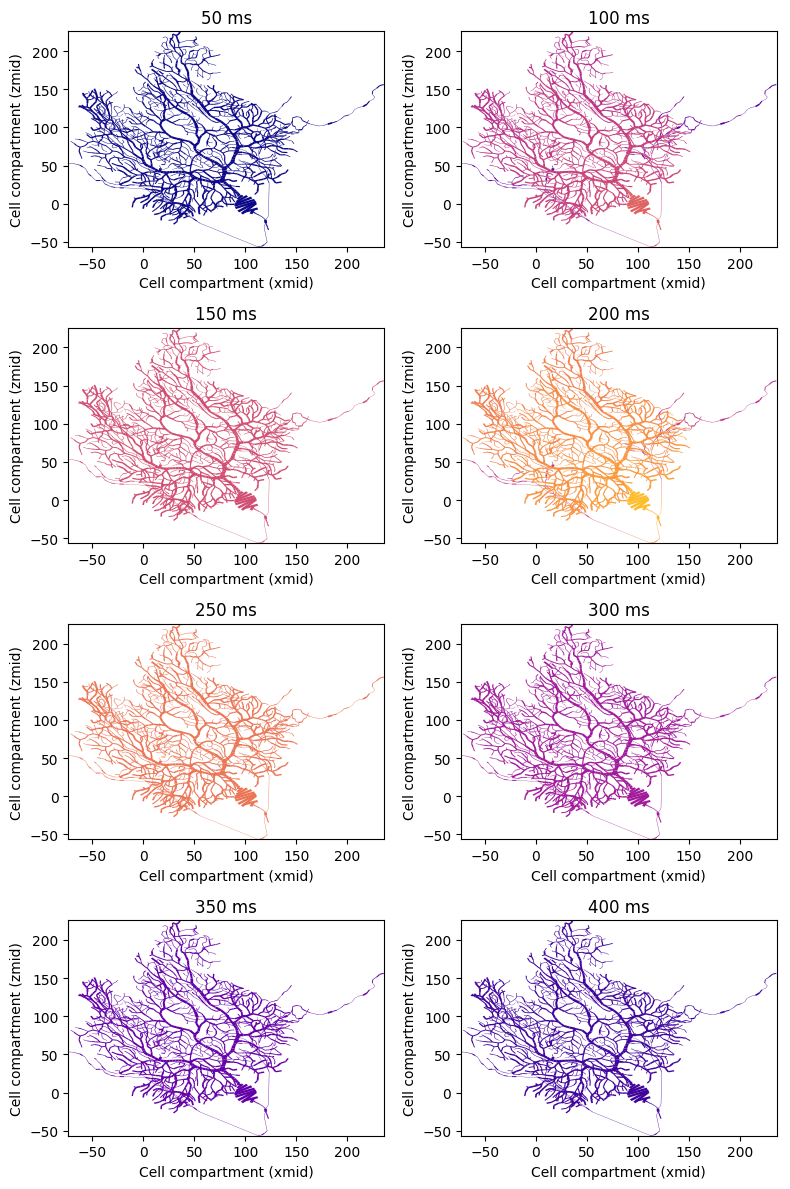

In [4]:
# plot generator cell vmem with morphology

timepoint_50 = int(50/(2**-6)) # simulation time point
timepoint_100 = int(100/(2**-6))
timepoint_150 = int(150/(2**-6))
timepoint_200 = int(200/(2**-6))
timepoint_250 = int(250/(2**-6))
timepoint_300 = int(300/(2**-6))
timepoint_350 = int(350/(2**-6))
timepoint_400 = int(400/(2**-6))

vmax = generator_cell.vmem.max()
vmin = generator_cell.vmem.min()

plt.figure(figsize=(8, 12), dpi=100)
plt.subplot(421)
plot_cell(generator_cell, x_off=100, voltage=generator_cell.vmem[:,timepoint_50], palette='plasma',
             vmin=vmin, vmax=vmax)
plt.title('50 ms')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

plt.subplot(422)
plot_cell(generator_cell, x_off=100, voltage=generator_cell.vmem[:,timepoint_100], palette='plasma',
             vmin=vmin, vmax=vmax)
plt.title('100 ms')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

plt.subplot(423)
plot_cell(generator_cell, x_off=100, voltage=generator_cell.vmem[:,timepoint_150], palette='plasma',
             vmin=vmin, vmax=vmax)
plt.title('150 ms')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

plt.subplot(424)
plot_cell(generator_cell, x_off=100, voltage=generator_cell.vmem[:,timepoint_200], palette='plasma',
             vmin=vmin, vmax=vmax)
plt.title('200 ms')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

plt.subplot(425)
plot_cell(generator_cell, x_off=100, voltage=generator_cell.vmem[:,timepoint_250], palette='plasma',
             vmin=vmin, vmax=vmax)
plt.title('250 ms')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

plt.subplot(426)
plot_cell(generator_cell, x_off=100, voltage=generator_cell.vmem[:,timepoint_300], palette='plasma',
             vmin=vmin, vmax=vmax)
plt.title('300 ms')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

plt.subplot(427)
plot_cell(generator_cell, x_off=100, voltage=generator_cell.vmem[:,timepoint_350], palette='plasma',
             vmin=vmin, vmax=vmax)
plt.title('350 ms')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

plt.subplot(428)
plot_cell(generator_cell, x_off=100, voltage=generator_cell.vmem[:,timepoint_400], palette='plasma',
             vmin=vmin, vmax=vmax)
plt.title('400 ms')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

plt.tight_layout()

plt.savefig('purkinje_gen_timepoints.png', dpi=300)


# # plot generator cell vmem interactively over time
# def plot_time(t=100):
#     plot_cell(generator_cell, x_off=100, voltage=generator_cell.vmem[:,t], palette='plasma')
#     plt.title('Generator: membrane voltage over time')
# wdg.interact(plot_time)

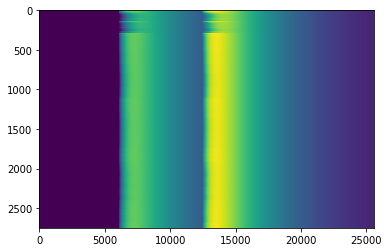

In [5]:
plt.imshow(generator_cell.vmem, aspect='auto')

## Creating receptor_cell

In [6]:
# delete old sections from NEURON namespace
LFPy.cell.neuron.h("forall delete_section()")

# initialize cell instance, using the LFPy.Cell class
receptor_cell = LFPy.Cell(**cellParameters)
receptor_cell.set_rotation(x=4.729, y=-3.166)
receptor_cell.xmid += 100          # added distance of the electrodes to the receptor cell in x plane

# time of extracellular field simulation
t = np.arange(electrode.LFP.shape[1]) * receptor_cell.dt

# insert external field generated by the generator cell recorded in electrodes
receptor_cell.insert_v_ext(electrode.LFP, t)

# perform receptor cell simulation
receptor_cell.simulate(rec_vmem=True)

	1 
	30 
	0 
	0 
	0 
	0 
Purkinje cell morphology defined

	1 
Overwriting custom temperature of 34.00. New temperature is 34.00


### Find index positions in generator_cell and receptor_cell

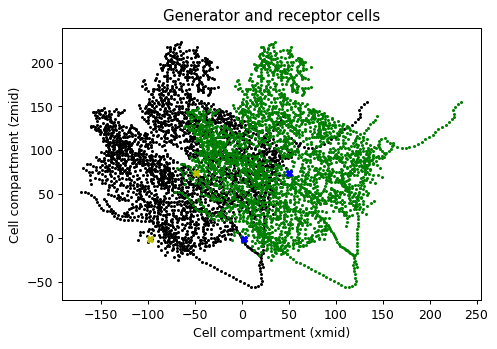

In [23]:
gen_positions = np.array(list(zip(generator_cell.xmid, generator_cell.zmid)))  # array all cell positions
rec_positions = np.array(list(zip(receptor_cell.xmid, receptor_cell.zmid)))  # array all cell positions

dend1_index = generator_cell.get_closest_idx(x=-100, y=0, z=0)
dend2_index = generator_cell.get_closest_idx(x=-50, y=0, z=75)

gen_dend1_pos = gen_positions[dend1_index] 
gen_dend2_pos = gen_positions[dend2_index] 

dend1_index = receptor_cell.get_closest_idx(x=0, y=0, z=0)
dend2_index = receptor_cell.get_closest_idx(x=50, y=0, z=75)

rec_dend1_pos = rec_positions[dend1_index] 
rec_dend2_pos = rec_positions[dend2_index] 

# plot generator and receptor compartments with target
plt.figure(figsize=(6,4), dpi=90)
plt.scatter(generator_cell.xmid, generator_cell.zmid,s=2,color='k')  
plt.scatter(receptor_cell.xmid, receptor_cell.zmid,s=2,color='g') 
plt.scatter(gen_dend1_pos[0],gen_dend1_pos[1],s=25,color='y', marker='X')       
plt.scatter(gen_dend2_pos[0],gen_dend2_pos[1],s=25,color='y', marker='X')        
plt.scatter(rec_dend1_pos[0],rec_dend1_pos[1],s=25,color='b', marker='X')        
plt.scatter(rec_dend2_pos[0],rec_dend2_pos[1],s=25,color='b', marker='X')        
plt.title('Generator and receptor cells')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')
plt.savefig('purkinje_locations.png', dpi=300)

### Plot Vmem in receptor cell over time

Text(0.5,0,'Time (ms)')

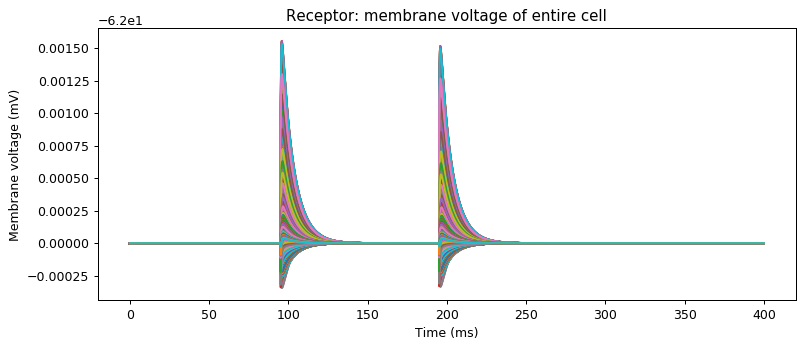

In [8]:
plt.figure(figsize=(10,4), dpi=90)

# plot vmem of all receptor cell compartments over time
plt.plot(receptor_cell.tvec,receptor_cell.vmem.T);
plt.title('Receptor: membrane voltage of entire cell')
plt.ylabel('Membrane voltage (mV)')
plt.xlabel('Time (ms)')
# plt.yticks([-62.00015, -62.0001, -62.0000, -61.9999, -61.99985],['', -62.0001, -62.0000, -61.9999, ''])
# axis.ticklabel_format(axis='both', style='plain', scilimits=(-10,10))
plt.savefig('purkinje_rec_vmem_time.png', dpi=300)

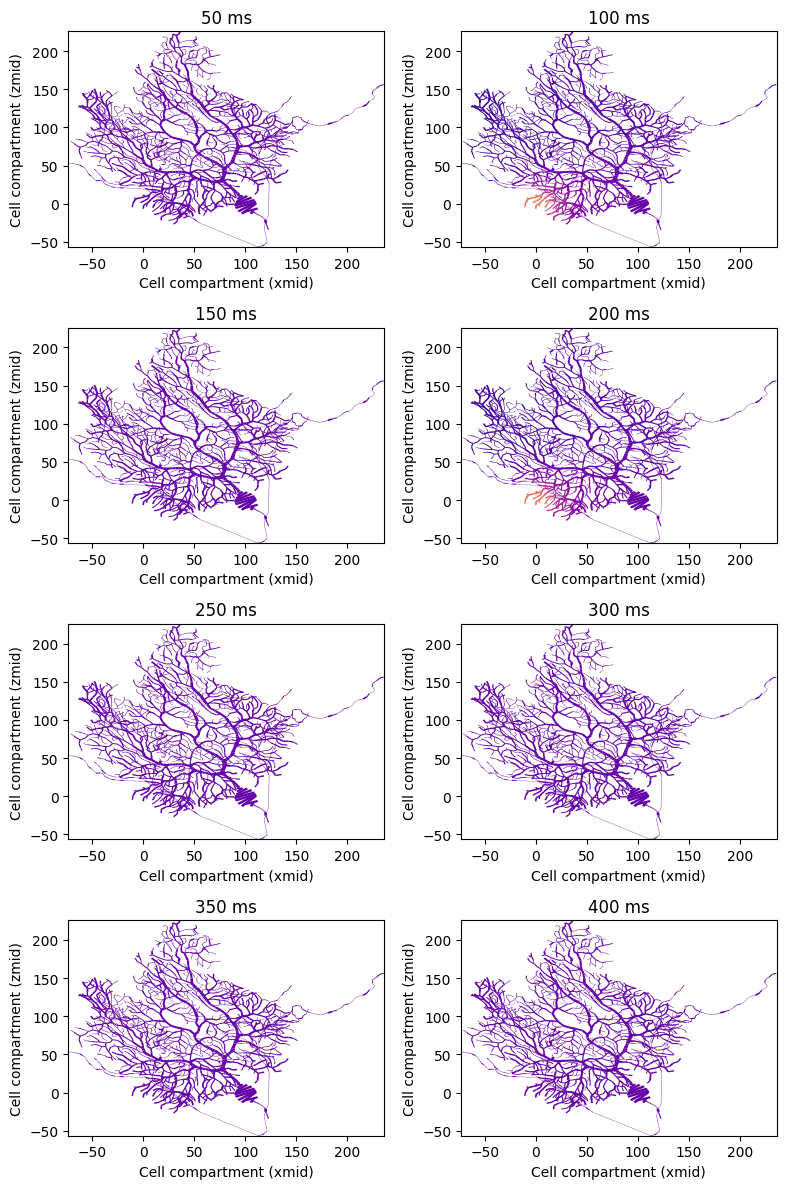

In [9]:
# plot receptor cell vmem with morphology

vmax = receptor_cell.vmem.max()
vmin = receptor_cell.vmem.min()

plt.figure(figsize=(8, 12), dpi=100)
plt.subplot(421)
plot_cell(receptor_cell, x_off=100, voltage=receptor_cell.vmem[:,timepoint_50], palette='plasma', vmin=vmin, vmax=vmax)
plt.title('50 ms')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

plt.subplot(422)
plot_cell(receptor_cell, x_off=100, voltage=receptor_cell.vmem[:,timepoint_100], palette='plasma', vmin=vmin, vmax=vmax)
plt.title('100 ms')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

plt.subplot(423)
plot_cell(receptor_cell, x_off=100, voltage=receptor_cell.vmem[:,timepoint_150], palette='plasma', vmin=vmin, vmax=vmax)
plt.title('150 ms')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

plt.subplot(424)
plot_cell(receptor_cell, x_off=100, voltage=receptor_cell.vmem[:,timepoint_200], palette='plasma', vmin=vmin, vmax=vmax)
plt.title('200 ms')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

plt.subplot(425)
plot_cell(receptor_cell, x_off=100, voltage=receptor_cell.vmem[:,timepoint_250], palette='plasma', vmin=vmin, vmax=vmax)
plt.title('250 ms')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

plt.subplot(426)
plot_cell(receptor_cell, x_off=100, voltage=receptor_cell.vmem[:,timepoint_300], palette='plasma', vmin=vmin, vmax=vmax)
plt.title('300 ms')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

plt.subplot(427)
plot_cell(receptor_cell, x_off=100, voltage=receptor_cell.vmem[:,timepoint_350], palette='plasma', vmin=vmin, vmax=vmax)
plt.title('350 ms')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

plt.subplot(428)
plot_cell(receptor_cell, x_off=100, voltage=receptor_cell.vmem[:,timepoint_400], palette='plasma', vmin=vmin, vmax=vmax)
plt.title('400 ms')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

plt.tight_layout()

# # plot receptor cell vmem interactively over time
# def plot_time(t=100):
#     plot_cell(receptor_cell, x_off=100, voltage=receptor_cell.vmem[:,t], palette='plasma', vmin=vmin, vmax=vmax)
#     plt.title('Receptor: membrane voltage over time')
# wdg.interact(plot_time)

plt.savefig('purkinje_rec_timepoints.png', dpi=300)

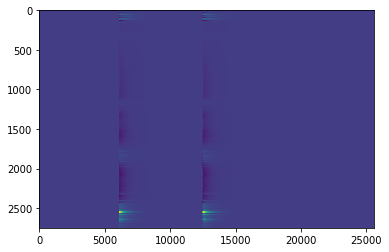

In [10]:
plt.imshow(receptor_cell.vmem, aspect='auto')

### Plot Vmem in generator_cell and receptor_cell 

Gen Vmem soma var: 5.310421530877527
Rec Vmem soma peak: -61.999970341819235
Rec Vmem soma var: 4.2228902728425055e-05
Gen Vmem dend1 var: 5.178281885589598
Rec Vmem dend1 peak: -61.9984482526406
Rec Vmem dend1 var: 0.0015517473597768117
Gen Vmem dend2 var: 5.170908413653073
Rec Vmem dend2 peak: -62.0
Rec Vmem dend2 var: 4.607819660407131e-05


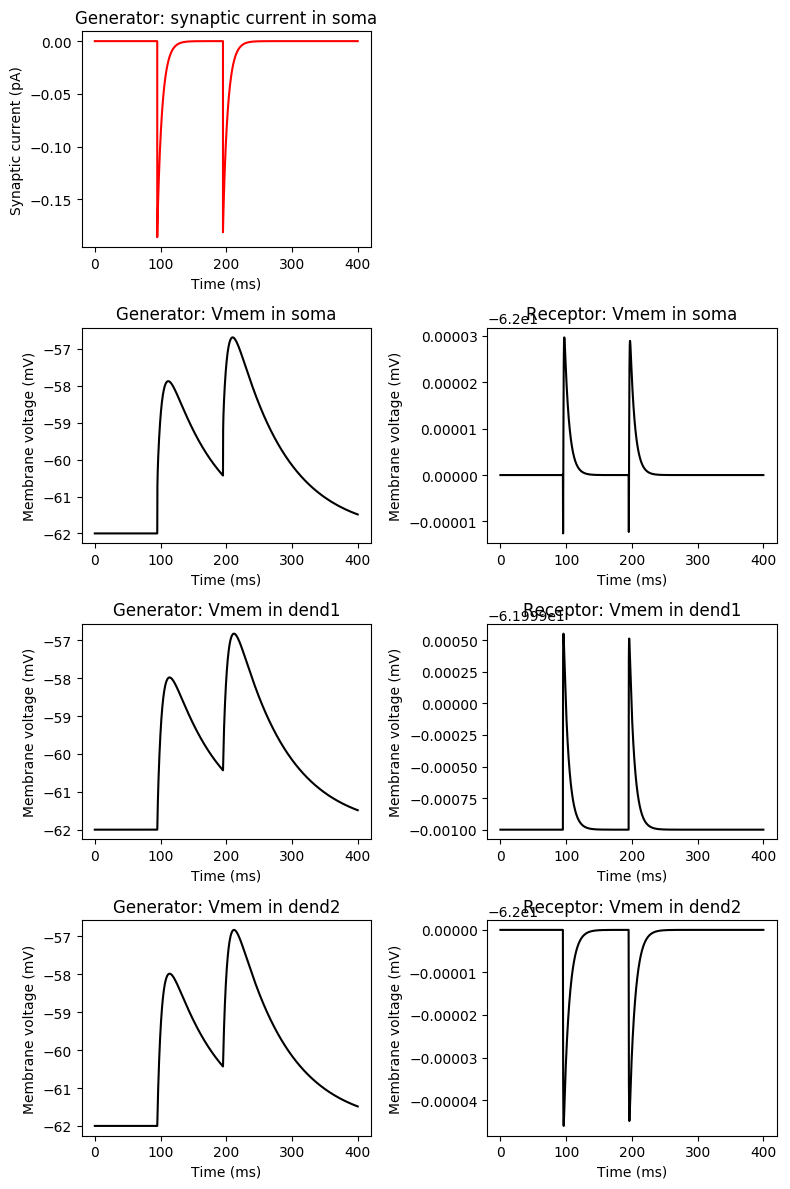

In [11]:
plt.figure(figsize=(8, 12), dpi=100)
plt.subplot(421)
plt.plot(generator_cell.tvec, synapse.i, 'r'), plt.title('Generator: synaptic current in soma')
plt.xlabel('Time (ms)')
plt.ylabel('Synaptic current (pA)')

plt.subplot(423)
plt.plot(generator_cell.tvec, generator_cell.somav, 'k'), plt.title('Generator: Vmem in soma')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane voltage (mV)')

plt.subplot(424)
plt.plot(receptor_cell.tvec, receptor_cell.somav, 'k'), plt.title('Receptor: Vmem in soma')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane voltage (mV)')

plt.subplot(425)
plt.plot(generator_cell.tvec, generator_cell.vmem[dend1_index], 'k'), plt.title('Generator: Vmem in dend1')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane voltage (mV)')

plt.subplot(426)
plt.plot(receptor_cell.tvec, receptor_cell.vmem[dend1_index], 'k'), plt.title('Receptor: Vmem in dend1')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane voltage (mV)')

plt.subplot(427)
plt.plot(generator_cell.tvec, generator_cell.vmem[dend2_index], 'k'), plt.title('Generator: Vmem in dend2')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane voltage (mV)')

plt.subplot(428)
plt.plot(receptor_cell.tvec, receptor_cell.vmem[dend2_index], 'k'), plt.title('Receptor: Vmem in dend2')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane voltage (mV)')

plt.tight_layout()

plt.savefig('purkinje_gen_rec_vmem.png', dpi=300)

print('Gen Vmem soma var:', max(generator_cell.somav)-min(generator_cell.somav))
print('Rec Vmem soma peak:', max(receptor_cell.somav))
print('Rec Vmem soma var:', max(receptor_cell.somav)-min(receptor_cell.somav))

print('Gen Vmem dend1 var:', max(generator_cell.vmem[dend1_index])-min(generator_cell.vmem[dend1_index]))
print('Rec Vmem dend1 peak:', max(receptor_cell.vmem[dend1_index]))
print('Rec Vmem dend1 var:', max(receptor_cell.vmem[dend1_index])-min(receptor_cell.vmem[dend1_index]))

print('Gen Vmem dend2 var:', max(generator_cell.vmem[dend2_index])-min(generator_cell.vmem[dend2_index]))
print('Rec Vmem dend2 peak:', max(receptor_cell.vmem[dend2_index]))
print('Rec Vmem dend2 var:', max(receptor_cell.vmem[dend2_index])-min(receptor_cell.vmem[dend2_index]))